In [1]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.0/869.0 kB 20.9 MB/s eta 0:00:0000:01


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from collections import Counter
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


0: 640x640 1 car_plate, 585.4ms
Speed: 19.3ms preprocess, 585.4ms inference, 22.1ms postprocess per image at shape (1, 3, 640, 640)


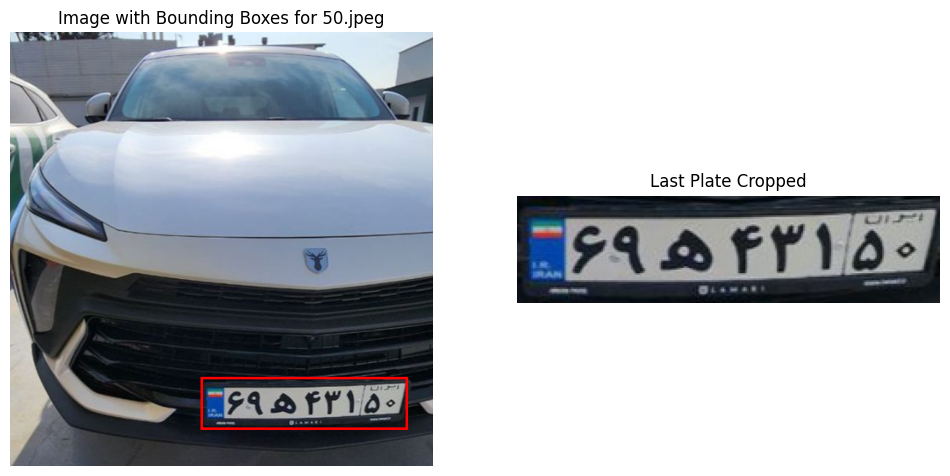


0: 576x640 1 car_plate, 383.0ms
Speed: 2.9ms preprocess, 383.0ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 640)


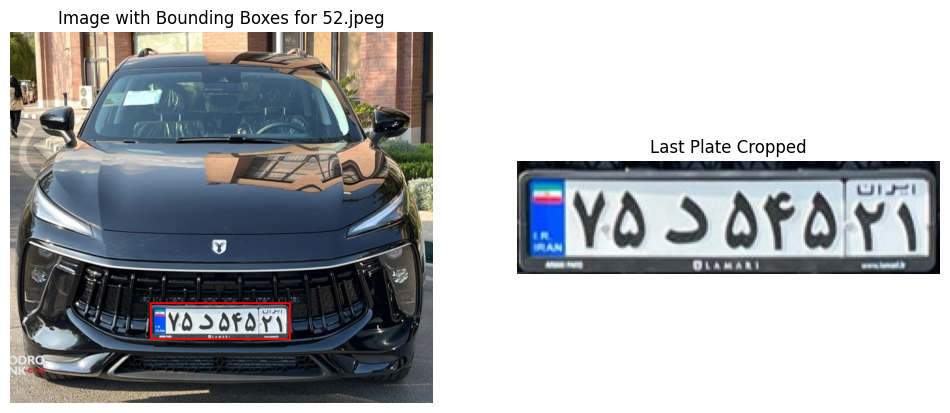

In [4]:
import os
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from ultralytics import YOLO
import numpy as np

model = YOLO('/kaggle/input/new-car-models/IranianCarLicenceRecognition/best.pt')

test_images_dir = '/kaggle/input/new-car-models/IranianCarLicenceRecognition/Test'
output_dir = '/kaggle/working/CarPlates'
os.makedirs(output_dir, exist_ok=True)

test_images = [os.path.join(test_images_dir, f) for f in os.listdir(test_images_dir) if os.path.isfile(os.path.join(test_images_dir, f))]

for image_path in test_images:
    img = Image.open(image_path)
    img_with_boxes = img.copy()
    draw = ImageDraw.Draw(img_with_boxes)

    results = model(img)
    for result in results:
        boxes = result.boxes.xyxy.cpu().numpy()
        confidences = result.boxes.conf.cpu().numpy()
        labels = result.boxes.cls.cpu().numpy()

        for i, box in enumerate(boxes):
            if labels[i] == 0:
                x1, y1, x2, y2 = map(int, box)
                draw.rectangle([x1, y1, x2, y2], outline="red", width=3)
                plate_img = img.crop((x1, y1, x2, y2))
                plate_filename = f"{os.path.basename(image_path).split('.')[0]}_plate_{i}.png"
                plate_img.save(os.path.join(output_dir, plate_filename))

    plt.figure(figsize=(12, 8))
    plt.subplot(1, 2, 1)
    plt.imshow(img_with_boxes)
    plt.title(f'Image with Bounding Boxes for {os.path.basename(image_path)}')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(plate_img)
    plt.title(f'Last Plate Cropped')
    plt.axis('off')

    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 774ms/step


I0000 00:00:1723592150.257428     127 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-08-13 23:35:50.259471: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


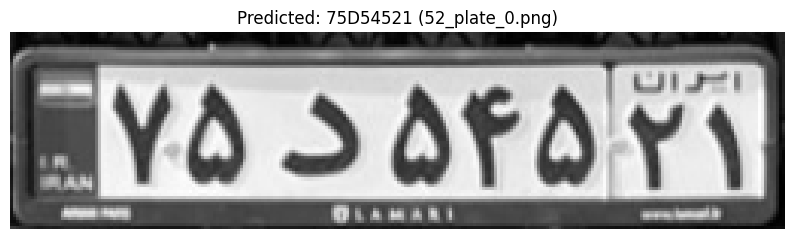

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


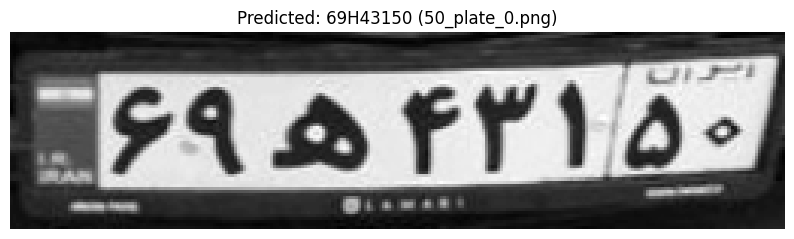

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os

img_width = 256
img_height = 65
max_length = 8

model_path = '/kaggle/input/new-car-models/IranianCarLicenceRecognition/ocr_best_model.keras'
model = keras.models.load_model(model_path)

characters = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'H', 'J', 'L', 'M', 'N', 'P', 'Q', 'S', 'T', 'V', 'W', 'X', 'Y', 'Z', '»']
char_to_num = layers.StringLookup(vocabulary=characters, mask_token=None)
num_to_char = layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True)

def preprocess_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=1)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [img_height, img_width])
    img = tf.transpose(img, perm=[1, 0, 2])
    img = tf.expand_dims(img, axis=0)
    return img

def predict_label(img):
    pred = model.predict(img)
    pred = pred.argmax(axis=-1)
    predicted_label = tf.strings.reduce_join(num_to_char(pred)).numpy().decode("utf-8")
    return predicted_label

def process_images_in_directory(directory_path):
    for filename in os.listdir(directory_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(directory_path, filename)
            img = preprocess_image(image_path)
            predicted_label = predict_label(img)
            
            img_visual = (img.numpy()[0] * 255).astype("uint8")
            plt.figure(figsize=(10, 5))
            plt.imshow(img_visual[:, :, 0].T, cmap="gray")
            plt.title(f"Predicted: {predicted_label} ({filename})")
            plt.axis("off")
            plt.show()

directory_path = '/kaggle/working/CarPlates'
process_images_in_directory(directory_path)